# CTEFNet: 基于 CNN 与迁移学习的厄尔尼诺预测模型

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/zh_cn/medium-range/mindspore_graphcast.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/zh_cn/medium-range/mindspore_graphcast.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindearth/docs/source_zh_cn/medium-range/graphcast.ipynb)

## 概述

CTEFNet是一种基于深度学习的 ENSO 预测模型，其使用 2D CNN 从气象数据中提取特征，将多个时点特征拼接为时间序列后输入 Transformer Encoder 进行时序分析和 ENSO 预测。 与之前的深度学习模型相比，CTEFNet的有效预测时长延长至19个月。

本教程介绍了CTEFNet的研究背景和技术路径，并展示了如何通过MindEarth训练和快速推理模型。

## CTEFNet

下图展示了CTEFNet的网络架构

<img src="images/CTEFNet.png" alt="CTEFNet" style="width: 800px;"/>

CTEFNet 主要由 CNN 特征提取器和 Transformer 编码器两部分组成。

CNN 部分包含三个卷积层、三个最大池化层；以连续 12 个月的海洋、大气指标月异常值作为输入。

提取出的特征排列为序列后将输入 Transformer 编码器进行序列分析，并与CNN构成残差结构，最后经过全连接层输出观测期 12 个月的Nino3.4 指数估计值及后续 23 个月的 Nino3.4 指数预测值。

## 技术路径

MindSpore Earth求解该问题的具体流程如下:

1. 创建数据集
2. 模型构建
3. 损失函数
4. 模型训练
5. 模型评估与可视化

训练和测试所用的数据集可以在: [mindearth/dataset](https://download-mindspore.osinfra.cn/mindscience/mindearth/dataset/enso_dataset.zip) 下载。

In [1]:
import os
import random

import numpy as np

from mindspore import set_seed
from mindspore import context
import mindspore.dataset as ds
from mindspore.train.serialization import load_param_into_net

下述`src`可以在[ensoforcast/src](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/medium-range/ensoforecast/src)下载。

In [2]:
from mindearth.module import Trainer
from mindearth.utils import load_yaml_config, create_logger
from src import WeightedLoss, CTEFNet, InferenceModule, EvaluateCallBack
from src import ReanalysisData, plot_correlation, get_param_dict, init_dataloader

In [3]:
set_seed(0)
np.random.seed(0)
random.seed(0)

模型涉及的参数、优化器、数据配置见[config](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/ensoforecast/configs/pretrain.yaml)。

In [4]:
config = load_yaml_config("./configs/pretrain.yaml")
context.set_context(mode=context.PYNATIVE_MODE, device_target="GPU", device_id=0)

## 创建数据集

在[dataset](https://download-mindspore.osinfra.cn/mindscience/mindearth/dataset/enso_dataset.zip)路径下，下载训练数据集验证数据集到 `./dataset`目录。

修改[configs/pretrain.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/ensoforcast/configs/pretrain.yaml)和[configs/finetune.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/ensoforcast/configs/finetune.yaml)配置文件中的`root_dir`参数，该参数设置了数据集的路径。

`./dataset`中的目录结构如下所示：

``` markdown
.
dataset
├── CMIP5_nino34.npy
├── CMIP5_sst_ssh_slp.npy
├── SODA_nino34.npy
└── SODA_sst_ssh_slp.npy

```


## 模型构建

模型初始化：

In [5]:
config['data']['obs_time'] = 12 # 观测时长
config['data']['pred_time'] = 23 # 预测时长
logger = create_logger(os.path.join(os.path.abspath(config['summary']["summary_dir"]), "results.log"))

In [6]:
data_params = config.get("data")
model_params = config.get("model")
model = CTEFNet(
        cov_hidden_channels=model_params.get('cov_hidden_channels'),
        cov_out_channels=model_params.get('cov_out_channels'),
        heads=model_params.get('heads'),
        num_layer=model_params.get('num_layer'),
        feedforward_dims=model_params.get('feedforward_dims'),
        dropout=model_params.get('dropout'),
        obs_time=data_params.get('obs_time'),
        pred_time=data_params.get('pred_time')
    )

## 损失函数

CTEFNet 在模型训练中使用自定义加权损失。计算公式为：

<img src="images/Loss.png" alt="Loss" style="width: 600px;"/>

In [7]:
opt_params = config.get("optimizer")
loss_fn = WeightedLoss(
    lambda_1=opt_params.get('loss_alpha'),
    lambda_2=opt_params.get('loss_beta'),
    lambda_3=opt_params.get('loss_gamma'),
    obs_time=data_params.get('obs_time')
)

## 模型训练

在本教程中，我们继承了`Trainer`并重写了`get_dataset`成员函数来加入自定义数据，并重写了`get_callback`成员函数来在训练过程中对测试数据集执行推理。模型训练可以分为预训练和调优两步。

MindSpore Earth提供训练和推理接口，使用2.0.0及之后的MindSpore训练网络。

In [8]:
class CTEFTrainer(Trainer):
    def __init__(self, config, model, loss_fn, logger):
        super().__init__(config, model, loss_fn, logger)
        self.train_dataset, self.valid_dataset = self.get_dataset()
        self.pred_cb = self.get_callback()

    def get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb


    def get_dataset(self):
        train_dataloader, valid_dataloader = init_dataloader(self.config)
        return train_dataloader, valid_dataloader

首先使用 CMIP5 数据进行预训练。

In [9]:
config['data']["train_dataset"] = "CMIP5" # 训练数据集
config['data']["train_period"] = [1861, 2004] # 训练周期
config['data']["valid_dataset"] = "Reanalysis" # 评估数据集
config['data']["valid_period"] = [1941, 1983] # 评估周期
config['data']["t_in"] = 1  # 训练阶段
config['data']["t_out_train"] = 1  # 训练阶段
config['optimizer']['name'] = 'adam'  # 优化器
config['optimizer']['initial_lr'] = 0.0008  # 学习率
config['optimizer']['epochs'] = 3  # 训练批次

trainer = CTEFTrainer(config, model, loss_fn, logger)
trainer.train()

2024-01-04 16:48:10,192 - pretrain.py[line:215] - INFO: steps_per_epoch: 60


epoch: 1 step: 1, loss is 1.5188606
epoch: 1 step: 2, loss is 1.5849463
epoch: 1 step: 3, loss is 1.567341
epoch: 1 step: 4, loss is 1.55313
epoch: 1 step: 5, loss is 1.5645213
epoch: 1 step: 6, loss is 1.530109
epoch: 1 step: 7, loss is 1.4947193
epoch: 1 step: 8, loss is 1.6096498
epoch: 1 step: 9, loss is 1.4316063
epoch: 1 step: 10, loss is 1.3057346
epoch: 1 step: 11, loss is 1.274231
epoch: 1 step: 12, loss is 1.181603
epoch: 1 step: 13, loss is 1.3375003
epoch: 1 step: 14, loss is 1.3464673
epoch: 1 step: 15, loss is 1.2914193
epoch: 1 step: 16, loss is 1.188085
epoch: 1 step: 17, loss is 1.1063777
epoch: 1 step: 18, loss is 1.0297971
epoch: 1 step: 19, loss is 1.0219135
epoch: 1 step: 20, loss is 1.0448943
epoch: 1 step: 21, loss is 0.9871134
epoch: 1 step: 22, loss is 0.9697764
epoch: 1 step: 23, loss is 0.8869653
epoch: 1 step: 24, loss is 0.83613193
epoch: 1 step: 25, loss is 0.81286037
epoch: 1 step: 26, loss is 0.8561025
epoch: 1 step: 27, loss is 0.8827102
epoch: 1 step: 

使用1984年前的 SODA 再分析数据对模型进行调优

In [10]:
config['data']["train_dataset"] = "Reanalysis" # 训练数据集
config['data']["train_period"] = [1941, 1983] # 训练周期
config['data']["valid_dataset"] = "Reanalysis" # 评估数据集
config['data']["valid_period"] = [1984, 2008] # 评估周期
config['data']["t_in"] = 2  # 训练阶段
config['data']["t_out_train"] = 1  # 训练阶段
config['optimizer']['name'] = 'sgd'  # 优化器
config['optimizer']['finetune_lr'] = 0.001  # 调优学习率
config['optimizer']['epochs'] = 100  # 训练批次

trainer = CTEFTrainer(config, model, loss_fn, logger)
trainer.train()

2024-01-04 16:49:23,276 - pretrain.py[line:215] - INFO: steps_per_epoch: 1


epoch: 1 step: 1, loss is 0.6054596
Train epoch time: 1675.850 ms, per step time: 1675.850 ms
epoch: 2 step: 1, loss is 0.5792351
Train epoch time: 2416.648 ms, per step time: 2416.648 ms
epoch: 3 step: 1, loss is 0.55488724
Train epoch time: 637.654 ms, per step time: 637.654 ms
epoch: 4 step: 1, loss is 0.5511505
Train epoch time: 373.729 ms, per step time: 373.729 ms
epoch: 5 step: 1, loss is 0.53579855
Train epoch time: 861.648 ms, per step time: 861.648 ms
epoch: 6 step: 1, loss is 0.53114736
Train epoch time: 368.341 ms, per step time: 368.341 ms
epoch: 7 step: 1, loss is 0.52704656
Train epoch time: 360.355 ms, per step time: 360.355 ms
epoch: 8 step: 1, loss is 0.52844036
Train epoch time: 390.446 ms, per step time: 390.446 ms
epoch: 9 step: 1, loss is 0.5157909
Train epoch time: 374.243 ms, per step time: 374.243 ms
epoch: 10 step: 1, loss is 0.52055264
Train epoch time: 846.829 ms, per step time: 846.829 ms
epoch: 11 step: 1, loss is 0.5075707
Train epoch time: 382.759 ms, pe

epoch: 89 step: 1, loss is 0.39630213
Train epoch time: 260.887 ms, per step time: 260.887 ms
epoch: 90 step: 1, loss is 0.39602667
Train epoch time: 745.354 ms, per step time: 745.354 ms
epoch: 91 step: 1, loss is 0.39271408
Train epoch time: 246.109 ms, per step time: 246.109 ms
epoch: 92 step: 1, loss is 0.3992708
Train epoch time: 245.204 ms, per step time: 245.204 ms
epoch: 93 step: 1, loss is 0.39485645
Train epoch time: 243.879 ms, per step time: 243.879 ms
epoch: 94 step: 1, loss is 0.3959085
Train epoch time: 245.995 ms, per step time: 245.995 ms
epoch: 95 step: 1, loss is 0.39440528
Train epoch time: 723.685 ms, per step time: 723.685 ms
epoch: 96 step: 1, loss is 0.40036404
Train epoch time: 243.884 ms, per step time: 243.884 ms
epoch: 97 step: 1, loss is 0.39797822
Train epoch time: 244.216 ms, per step time: 244.216 ms
epoch: 98 step: 1, loss is 0.3943558
Train epoch time: 242.548 ms, per step time: 242.548 ms
epoch: 99 step: 1, loss is 0.40187484
Train epoch time: 247.567

## 模型评估和可视化

完成训练后，我们使用ckpt进行推理。下述展示了nino3.4指数预测值、真实值的相关系数。

In [11]:
test_dataset = ReanalysisData(
    data_params.get('root_dir'),
    data_params.get('test_period'),
    data_params.get('obs_time'),
    data_params.get('pred_time')
)
test_dataloader = ds.GeneratorDataset(
    test_dataset,
    ["data", "index"],
    shuffle=False).batch(data_params.get('valid_batch_size'), False)

In [12]:
corr_list = []
for t in range(1, 2+1):
    param_dict, file_dir = get_param_dict(config, t)
    load_param_into_net(model, param_dict)
    logger.info(f"Load pre-trained model successfully, {file_dir}")
    inference_module = InferenceModule(model, config, logger)
    corr_list.append(inference_module.eval(test_dataloader)[data_params.get('obs_time'):])

2024-01-04 16:50:13,707 - 2085024365.py[line:5] - INFO: Load pre-trained model successfully, ./summary/ckpt/step_1


OBS Accuracy: 94.83%, Pred Accuracy: 66.41%, Pred Corr:
[0.95 0.91 0.88 0.83 0.79 0.75 0.72 0.71 0.71 0.71 0.71 0.7  0.69 0.68
 0.66 0.65 0.61 0.52 0.5  0.44 0.42 0.37 0.37]


2024-01-04 16:50:14,782 - 2085024365.py[line:5] - INFO: Load pre-trained model successfully, ./summary/ckpt/step_2


OBS Accuracy: 94.15%, Pred Accuracy: 67.44%, Pred Corr:
[0.95 0.91 0.88 0.83 0.79 0.75 0.71 0.71 0.7  0.7  0.71 0.71 0.7  0.69
 0.67 0.66 0.63 0.56 0.53 0.47 0.44 0.41 0.4 ]


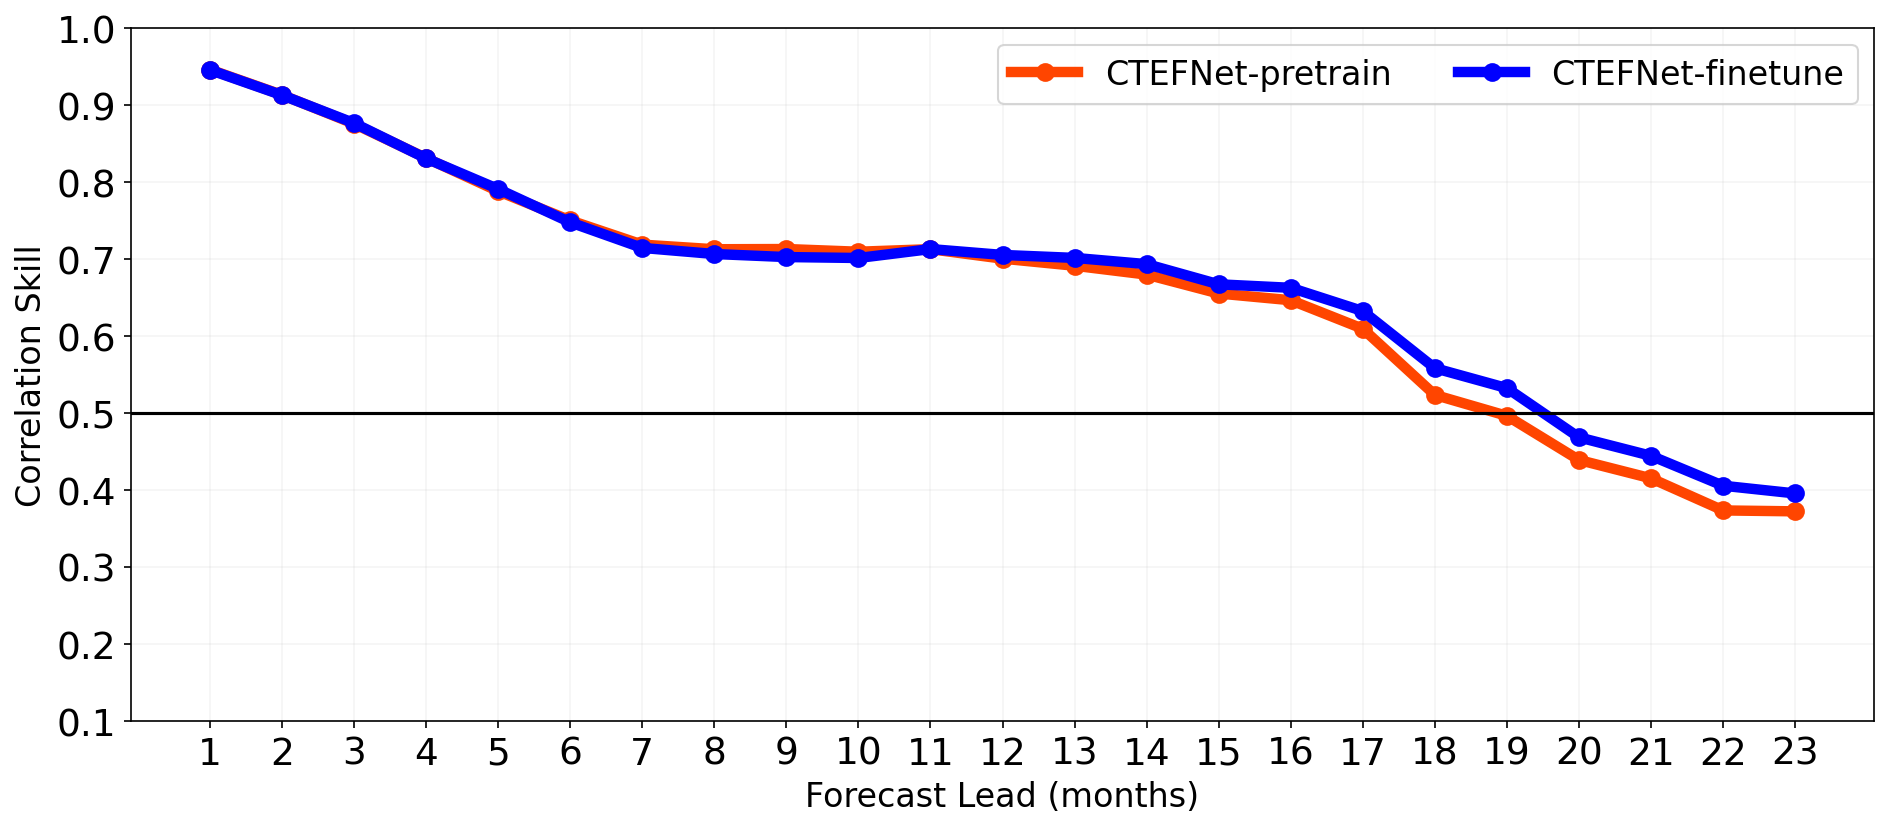

In [13]:
plot_correlation(config, corr_list)